In [1]:
from geomagio.edge import EdgeFactory
from geomagio.algorithm import Algorithm
from obspy.core import UTCDateTime, Stream,  Stats
import numpy as np
import scipy as sp
import scipy.linalg as spl
import scipy.signal as sps
import matplotlib.pyplot as pl
import datetime as dt
import json

In [2]:
"""Algorithm that converts from one geomagnetic coordinate system to a
    related geographic coordinate system, by using transformations generated
    from absolute, baseline measurements.
"""

from numpy.lib import stride_tricks as npls


import sys


class FilterAlgorithm(Algorithm):
    """Filter Algorithm"""

    def __init__(self, decimation=None, window=None, interval=None, 
                 location=None, inchannels=None, outchannels=None):
        Algorithm.__init__(self, inchannels=inchannels,
            outchannels=outchannels)
        self.numtaps=91
        # get filter window (standard intermagnet one-minute filter)
        self.window = sps.get_window(window=('gaussian', 15.8734), 
                                             Nx=self.numtaps)
        # normalize filter window
        self.window = self.window/np.sum(self.window)
        self.decimation = 60
        self.sample_period = 1.0
        self.data_type = None
        self.location = None
        self.inchannels = inchannels
        self.outchannels = outchannels


    def create_trace(self, channel, stats, data):
        """Utility to create a new trace object.

        Parameters
        ----------
        channel : str
            channel name.
        stats : obspy.core.Stats
            channel metadata to clone.
        data : numpy.array
            channel data.

        Returns
        -------
        obspy.core.Trace
            trace containing data and metadata.
        """
        stats = Stats(stats)
        if self.data_type is None:
            stats.data_type = 'variation'
        else:
            stats.data_type = self.data_type
        if self.data_type is None:
            stats.location = 'R0'
        else:
            stats.location = self.location

        trace = super(FilterAlgorithm, self).create_trace(channel, stats,
            data)
        return trace

    def process(self, stream):
        """Run algorithm for a stream.
        Processes all traces in the stream.
        Parameters
        ----------
        stream : obspy.core.Stream
            stream of data to process
        Returns
        -------
        out : obspy.core.Stream
            stream containing 1 trace per original trace.
        """

        out = Stream()
        
        trace_channels = []
        
        for trace in stream:
            trace_channels.append(trace.stats.channel)

        trace_chan_dict = dict(zip(trace_channels, self.outchannels))
        print(trace_chan_dict)
        
        for trace in stream:
            data = trace.data
            times = trace.times()
            half = self.numtaps//2
            step = self.decimation

            filtered = self.firfilter(data, self.window, step)
            print(len(filtered))
            
            stats=Stats(trace.stats)
            stats.channel = trace_chan_dict[trace.stats.channel]
            stats.starttime = trace.stats.starttime + half
            stats.delta = trace.stats.delta*step
            stats.npts = filtered.shape[0]
            stats.pop('processing')
            trace_out = self.create_trace(
                trace_chan_dict[trace.stats.channel], stats, filtered)

            out += trace_out

        return out
    
    @classmethod
    def firfilter(cls, data, window, step, allowed_bad = 0.1):
        """Run fir filter for a numpy array.
        Processes all traces in the stream.
        Parameters
        ----------
        data: numpy.ndarray
            array of data to process
        window: numpy.ndarray
            array of filter coefficients
        step: int
            ratio of output sample period to input sample period
            should always be an integer
        allowed_bad: float
            ratio of bad samples to total window size
        Returns
        -------
        filtered_out : numpy.ndarray
            stream containing filtered output
        """
        numtaps = len(window)
        half = numtaps//2

        # build view into data, with numtaps  chunks separated into 
        # overlapping 'rows'
        shape = data.shape[:-1] + (data.shape[-1] - numtaps + 1, 
                                   numtaps)
        
        strides = data.strides + (data.strides[-1],)
        
        as_s = npls.as_strided(data, shape=shape, strides=strides, 
                               writeable=False)
        
        print(as_s.shape)
        # build masked array for invalid entries
        as_masked = np.ma.masked_invalid(as_s[::step], copy=True)
        as_weight_sums =  np.dot(window, (~as_masked.mask).T)
        as_invalid_sums = np.sum(as_masked.mask)
            
        as_invalid_masked = np.ma.masked_greater(as_invalid_sums, 
                                                 np.floor(
                                                    allowed_bad*numtaps))

        print(np.dot(window, as_s[0].T))
        print(np.dot(window, as_s[-1].T))
        # apply filter
        filtered = np.ma.dot(window, as_masked.T)
        # re-normalize, especially important for partially filled windows
        filtered = np.divide(filtered, as_weight_sums)
        filtered.mask = as_invalid_masked.mask
        filtered_out = np.ma.filled(filtered, np.nan)
        
        print(len(filtered_out))

        return filtered_out

def get_input_interval(self, start, end, observatory=None, channels=None):
        """Get Input Interval

        start : UTCDateTime
            start time of requested output.
        end : UTCDateTime
            end time of requested output.
        observatory : string
            observatory code.
        channels : string
            input channels.

        Returns
        -------
        input_start : UTCDateTime
            start of input required to generate requested output
        input_end : UTCDateTime
            end of input required to generate requested output.
        """

        half = self.numtaps//2
        step = self.decimation
        start = start - half*self.interval
        end = end + half*self.interval

        return (start, end)


In [3]:
# excerpted from https://github.com/scipy/scipy/issues/7725#issuecomment-322094749
sample_rate = 10.0
cutoff = 0.35
width = 0.3
stop_db = 50.0
stop_db = np.abs(stop_db)

# Convert to normalized frequencies
nyq = 0.5*sample_rate
cutoff = cutoff / nyq
width = width / nyq

numtaps, beta = sps.kaiserord(ripple=stop_db, width=width)
numtaps |= 1
taps = sps.firwin(numtaps, cutoff, window=('kaiser', beta), scale=False)

In [4]:
numtaps

99

In [5]:
beta

4.533514120981248

In [6]:
taps

array([-3.52108034e-04, -4.06113064e-04, -4.32470789e-04, -4.18780310e-04,
       -3.53459036e-04, -2.27006071e-04, -3.33121617e-05,  2.29088259e-04,
        5.55936989e-04,  9.36459472e-04,  1.35296773e-03,  1.78094988e-03,
        2.18971137e-03,  2.54359924e-03,  2.80380086e-03,  2.93066500e-03,
        2.88644882e-03,  2.63835275e-03,  2.16166912e-03,  1.44284342e-03,
        4.82231450e-04, -7.03665956e-04, -2.08069626e-03, -3.59645375e-03,
       -5.18071820e-03, -6.74701354e-03, -8.19530200e-03, -9.41575888e-03,
       -1.02935010e-02, -1.07140735e-02, -1.05694378e-02, -9.76415629e-03,
       -8.22143526e-03, -5.88867560e-03, -2.74218686e-03,  1.20924955e-03,
        5.92223335e-03,  1.13182119e-02,  1.72846746e-02,  2.36780972e-02,
        3.03285588e-02,  3.70458597e-02,  4.36268766e-02,  4.98638150e-02,
        5.55529612e-02,  6.05034950e-02,  6.45459159e-02,  6.75396436e-02,
        6.93793953e-02,  7.00000000e-02,  6.93793953e-02,  6.75396436e-02,
        6.45459159e-02,  

In [7]:
sum(taps)

1.0027947751401205

In [8]:
taps=taps/sum(taps)

In [9]:
taps

array([-3.51126714e-04, -4.04981233e-04, -4.31265499e-04, -4.17613176e-04,
       -3.52473951e-04, -2.26373408e-04, -3.32193212e-05,  2.28449793e-04,
        5.54387600e-04,  9.33849573e-04,  1.34919703e-03,  1.77598640e-03,
        2.18360868e-03,  2.53651026e-03,  2.79598671e-03,  2.92249728e-03,
        2.87840433e-03,  2.63099969e-03,  2.15564458e-03,  1.43882223e-03,
        4.80887478e-04, -7.01704848e-04, -2.07489739e-03, -3.58643048e-03,
       -5.16627961e-03, -6.72820970e-03, -8.17246180e-03, -9.38951729e-03,
       -1.02648132e-02, -1.06842136e-02, -1.05399810e-02, -9.73694372e-03,
       -8.19852223e-03, -5.87226394e-03, -2.73454442e-03,  1.20587938e-03,
        5.90572816e-03,  1.12866682e-02,  1.72365025e-02,  2.36121067e-02,
        3.02440335e-02,  3.69426134e-02,  4.35052891e-02,  4.97248453e-02,
        5.53981359e-02,  6.03348726e-02,  6.43660273e-02,  6.73514115e-02,
        6.91860358e-02,  6.98049110e-02,  6.91860358e-02,  6.73514115e-02,
        6.43660273e-02,  

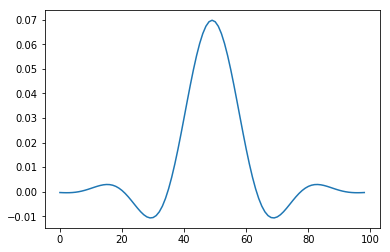

In [10]:
pl.plot(taps)

In [11]:
w, h = sps.freqz(taps,worN=4096)

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


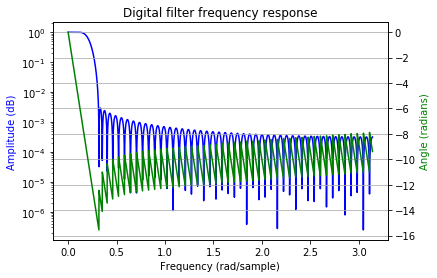

In [12]:
fig = pl.figure()
pl.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
pl.semilogy(w, np.abs(h), 'b')
pl.ylabel('Amplitude (dB)', color='b')
pl.xlabel('Frequency (rad/sample)')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
pl.plot(w, angles, 'g')
pl.ylabel('Angle (radians)', color='g')
pl.grid()
pl.axis('tight')
pl.show()

In [13]:
taps2 = sps.firwin2(99, freq=[0, 0.08, 0.5, 5.0], gain=[1, 10**(-25.0/20.0), 10**(-50.0/20.0), 0], nyq=5.0,antisymmetric=False)

In [14]:
taps2

array([0.00039358, 0.00040542, 0.00042685, 0.00045817, 0.00049988,
       0.00055217, 0.00061552, 0.00069004, 0.00077623, 0.00087413,
       0.00098429, 0.00110658, 0.00124152, 0.00138868, 0.00154838,
       0.00171962, 0.0019024 , 0.00209495, 0.0022969 , 0.00250572,
       0.00272089, 0.00293933, 0.0031609 , 0.00338241, 0.00360487,
       0.0038255 , 0.0040472 , 0.00426795, 0.00449303, 0.00472101,
       0.0049596 , 0.00520703, 0.005473  , 0.00575376, 0.00606023,
       0.00638447, 0.00673808, 0.00710631, 0.00750206, 0.00790081,
       0.00831959, 0.00872002, 0.00913063, 0.00949079, 0.00985902,
       0.01012713, 0.0104473 , 0.01054791, 0.01136939, 0.01245199,
       0.01136939, 0.01054791, 0.0104473 , 0.01012713, 0.00985902,
       0.00949079, 0.00913063, 0.00872002, 0.00831959, 0.00790081,
       0.00750206, 0.00710631, 0.00673808, 0.00638447, 0.00606023,
       0.00575376, 0.005473  , 0.00520703, 0.0049596 , 0.00472101,
       0.00449303, 0.00426795, 0.0040472 , 0.0038255 , 0.00360

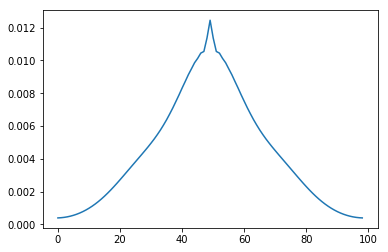

In [15]:
pl.plot(taps2)

In [16]:
w, h = sps.freqz(taps2)

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


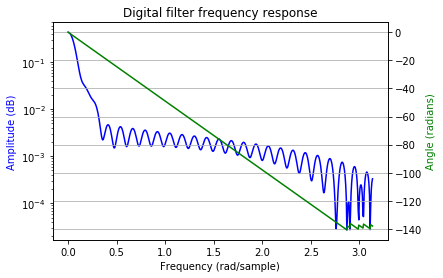

In [17]:
fig = pl.figure()
pl.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
pl.semilogy(w, np.abs(h), 'b')
pl.ylabel('Amplitude (dB)', color='b')
pl.xlabel('Frequency (rad/sample)')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
pl.plot(w, angles, 'g')
pl.ylabel('Angle (radians)', color='g')
pl.grid()
pl.axis('tight')
pl.show()

In [18]:
w = linspace(0.0,np.pi,512)
gd_samples = (numtaps/2 - 1)*ones_like(w)
gd_time = (numtaps/2 - 1)
gd_

NameError: name 'linspace' is not defined

In [19]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='butter')

In [20]:
a

array([1.33235776e-10, 1.33235776e-09, 5.99560994e-09, 1.59882932e-08,
       2.79795130e-08, 3.35754157e-08, 2.79795130e-08, 1.59882932e-08,
       5.99560994e-09, 1.33235776e-09, 1.33235776e-10])

In [21]:
b

array([   1.        ,   -8.59408415,   33.32337585,  -76.76079158,
        116.31514286, -121.13496375,   87.79973581,  -43.72962838,
         14.32217009,   -2.78514048,    0.24418385])

In [22]:
ts = np.asarray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
y = np.asarray([0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
tout, yout = sps.dimpulse((a,b,0.1), t=np.arange(0,199,0.1))

In [25]:
tout

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.987e+02, 1.988e+02,
       1.989e+02])

In [26]:
yout

(array([[ 1.33235776e-10],
        [ 2.47739724e-09],
        [ 2.28467044e-08],
        ...,
        [-3.46484535e-31],
        [-3.93725837e-31],
        [-4.19501562e-31]]),)

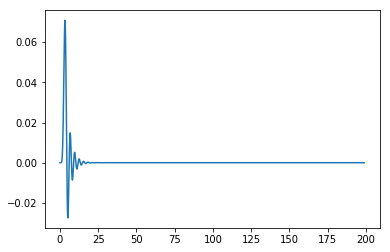

In [27]:
pl.plot(tout, yout[0])

In [28]:
#tbout, bout = sps.dlsim((a,b,0.1),t=np.append(tout,np.arange(0,199,0.1)) ,u=np.append((np.flip(yout[0],0)),(yout[0][-1]*np.ones_like(np.arange(0,199,0.1)))))
tbout, bout = sps.dimpulse((np.flip(yout,1),yout,0.1), t=np.arange(0,199,0.1))

ValueError: Denominator polynomial must be rank-1 array.

In [29]:
np.flip(yout,0)

array([[[ 1.33235776e-10],
        [ 2.47739724e-09],
        [ 2.28467044e-08],
        ...,
        [-3.46484535e-31],
        [-3.93725837e-31],
        [-4.19501562e-31]]])

In [30]:
yout

(array([[ 1.33235776e-10],
        [ 2.47739724e-09],
        [ 2.28467044e-08],
        ...,
        [-3.46484535e-31],
        [-3.93725837e-31],
        [-4.19501562e-31]]),)

In [31]:
tbout

NameError: name 'tbout' is not defined

In [32]:
bout

NameError: name 'bout' is not defined

In [33]:
pl.plot(tbout,bout)

NameError: name 'tbout' is not defined

In [34]:
np.max(bout)

NameError: name 'bout' is not defined

In [35]:
np.where(bout==np.max(bout))

NameError: name 'bout' is not defined

In [36]:
filt2 = bout[989-99:989+98]

NameError: name 'bout' is not defined

In [37]:
filt2

NameError: name 'filt2' is not defined

In [38]:
w, h = sps.freqz(filt2)

NameError: name 'filt2' is not defined

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


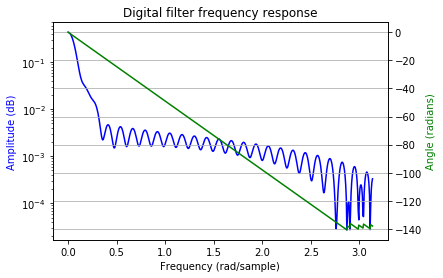

In [39]:
fig = pl.figure()
pl.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
pl.semilogy(w, np.abs(h), 'b')
pl.ylabel('Amplitude (dB)', color='b')
pl.xlabel('Frequency (rad/sample)')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
pl.plot(w, angles, 'g')
pl.ylabel('Angle (radians)', color='g')
pl.grid()
pl.axis('tight')
pl.show()

In [40]:
ts_imp = sps.filtfilt(a=a,b=b,x=ts)

ValueError: The length of the input vector x must be at least padlen, which is 33.

In [41]:
pl.plot(ts_imp)

NameError: name 'ts_imp' is not defined

In [42]:
np

<module 'numpy' from '/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/numpy/__init__.py'>

In [43]:
w, gd = sps.group_delay((a,b))

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/scipy/signal/filter_design.py:536: UserWarning: The group delay is singular at frequencies [2.970, 2.976, 2.982, 2.988, 2.994, 3.000, 3.007, 3.013, 3.019, 3.025, 3.031, 3.037, 3.043, 3.050, 3.056, 3.062, 3.068, 3.074, 3.080, 3.086, 3.093, 3.099, 3.105, 3.111, 3.117, 3.123, 3.129, 3.135], setting to 0
  format(", ".join("{0:.3f}".format(ws) for ws in w[singular]))


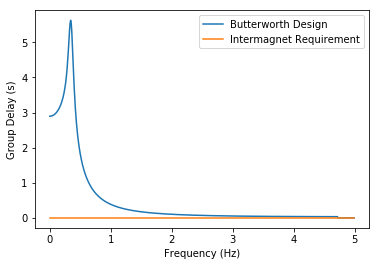

In [44]:
pl.plot(w*sample_rate/2/np.pi, gd/sample_rate, w*sample_rate/2/np.pi, 0.01*np.ones_like(w))
pl.xlabel('Frequency (Hz)')
pl.ylabel('Group Delay (s)')
pl.legend(('Butterworth Design', 'Intermagnet Requirement'))

In [45]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='cheby1')

In [46]:
w, gd = sps.group_delay((a,b))

/Users/aclaycomb/anaconda3/envs/geomagenv36/lib/python3.6/site-packages/scipy/signal/filter_design.py:536: UserWarning: The group delay is singular at frequencies [3.117, 3.123, 3.129, 3.135], setting to 0
  format(", ".join("{0:.3f}".format(ws) for ws in w[singular]))


In [47]:
a

array([5.23078520e-08, 3.13847112e-07, 7.84617780e-07, 1.04615704e-06,
       7.84617780e-07, 3.13847112e-07, 5.23078520e-08])

In [48]:
b

array([  1.        ,  -5.80308622,  14.10288385, -18.37054236,
        13.52693415,  -5.33825224,   0.88206754])

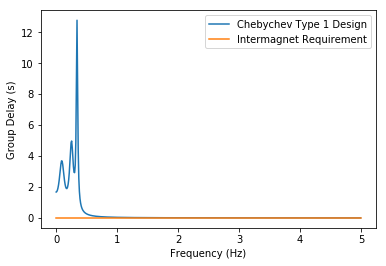

In [49]:
pl.plot(w*sample_rate/2/np.pi, gd/sample_rate, w*sample_rate/2/np.pi, 0.01*np.ones_like(w))
pl.xlabel('Frequency (Hz)')
pl.ylabel('Group Delay (s)')
pl.legend(('Chebychev Type 1 Design', 'Intermagnet Requirement'))

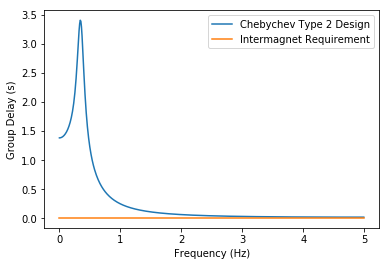

In [50]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='cheby2')
w, gd = sps.group_delay((a,b))
pl.plot(w*sample_rate/2/np.pi, gd/sample_rate, w*sample_rate/2/np.pi, 0.01*np.ones_like(w))
pl.xlabel('Frequency (Hz)')
pl.ylabel('Group Delay (s)')
pl.legend(('Chebychev Type 2 Design', 'Intermagnet Requirement'))

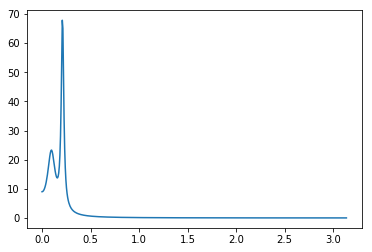

In [51]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='ellip')
w, gd = sps.group_delay((a,b))
pl.plot(w,gd)

In [52]:
a,b = sps.iirdesign(cutoff, cutoff+width, gpass=3.0, gstop=50.0, analog=False, ftype='bessel')
w, gd = sps.group_delay((a,b))
pl.plot(w,gd)

ValueError: bessel does not have order selection. Use iirfilter function.

In [53]:
200000/(2.0**24)

0.011920928955078125

In [54]:
w.shape

(512,)

In [55]:
a = EdgeFactory(cwbhost="166.154.45.158", host="166.154.45.158")

In [56]:
temp = a.get_timeseries(channels=['UK2'], starttime=UTCDateTime("2018-09-11T21:45:00Z"), endtime=UTCDateTime("2018-09-11T21:50:00Z"), observatory="GXX", type="variation", interval="minute")

In [57]:
temp

1 Trace(s) in Stream:
NT.GXX.R0.UK2 | 2018-09-11T21:44:57.840000Z - 2018-09-11T21:49:57.240000Z | 59.9 s, 6 samples

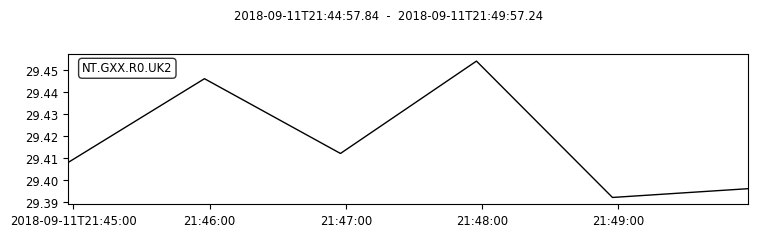

In [58]:
temp.plot()

In [59]:
b = temp[0]

In [60]:
b.times()

array([  0.  ,  59.88, 119.76, 179.64, 239.52, 299.4 ])

In [61]:
1/60

0.016666666666666666

In [3]:
c = EdgeFactory()

In [4]:
brt = c.get_timeseries(channels=['UK1'], starttime=UTCDateTime("2018-09-11T21:45:00Z"), endtime=UTCDateTime("2018-09-11T21:50:00Z"), observatory="BRT", type="variation", interval="minute")

In [5]:
brt[0].times()

array([  0.  ,  59.88, 119.76, 179.64, 239.52, 299.4 ])

In [6]:
dht = c.get_timeseries(channels=['MVH'], starttime=UTCDateTime("2018-09-10T21:45:00Z"), endtime=UTCDateTime("2018-09-10T21:50:00Z"), observatory="DHT", type="variation", interval="minute")

In [7]:
dht[0].times()

array([  0.,  60., 120., 180., 240., 300.])

In [8]:
bou1 = c.get_timeseries(channels=['SVH','SVE','SVZ','SSF'], starttime=UTCDateTime("2018-10-10T00:59:15Z"), endtime=UTCDateTime("2018-10-10T23:59:45Z"), observatory="BOU", type="variation", interval="second")

In [9]:
bou1

4 Trace(s) in Stream:
NT.BOU.R0.SVH | 2018-10-10T00:59:15.000000Z - 2018-10-10T23:59:45.000000Z | 1.0 Hz, 82831 samples
NT.BOU.R0.SVE | 2018-10-10T00:59:15.000000Z - 2018-10-10T23:59:45.000000Z | 1.0 Hz, 82831 samples
NT.BOU.R0.SVZ | 2018-10-10T00:59:15.000000Z - 2018-10-10T23:59:45.000000Z | 1.0 Hz, 82831 samples
NT.BOU.R0.SSF | 2018-10-10T00:59:15.000000Z - 2018-10-10T23:59:45.000000Z | 1.0 Hz, 82831 samples

In [10]:
bou1[0].stats.channel

'SVH'

In [11]:
filterer = FilterAlgorithm(outchannels=['MVH','MVE','MVZ','MSF'])

In [12]:
bouf = filterer.process(bou1)

{'SVH': 'MVH', 'SVE': 'MVE', 'SVZ': 'MVZ', 'SSF': 'MSF'}
(82741, 91)
20816.305334453184
20811.80458828588
1380
1380
(82741, 91)
-42.87911339556943
-43.71903955522315
1380
1380
(82741, 91)
47026.001101399066
47024.503480329244
1380
1380
(82741, 91)
51947.01403967162
51944.07858532072
1380
1380


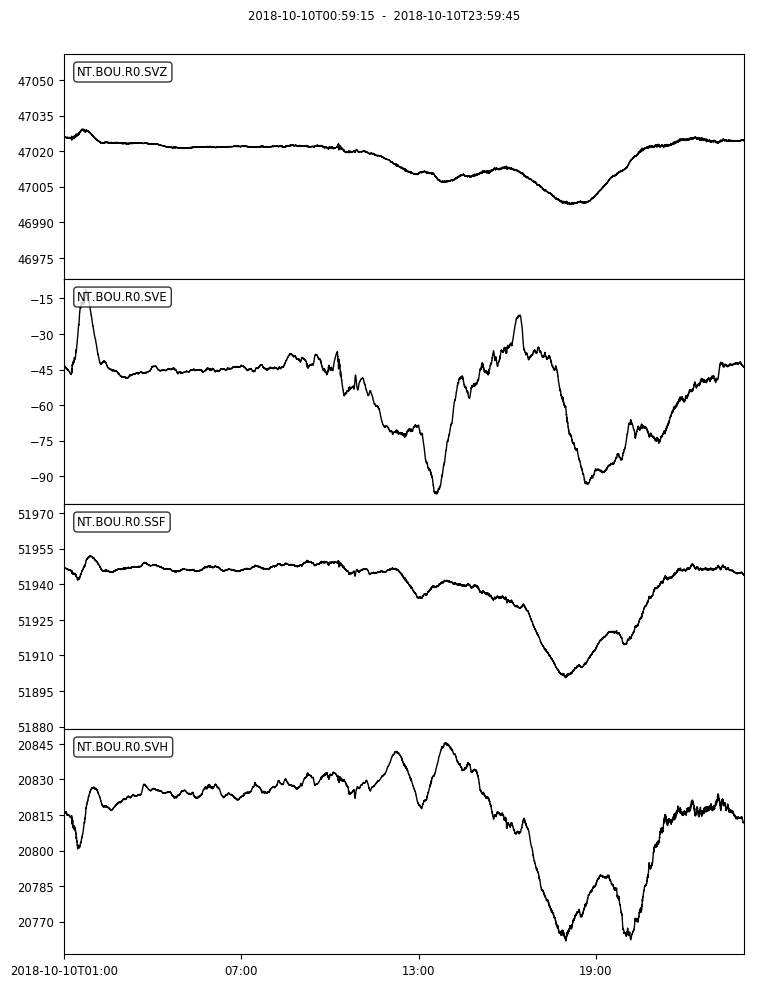

In [13]:
bou1.plot()

In [14]:
bouf

4 Trace(s) in Stream:
NT.BOU.R0.MVH | 2018-10-10T01:00:00.000000Z - 2018-10-10T23:59:00.000000Z | 60.0 s, 1380 samples
NT.BOU.R0.MVE | 2018-10-10T01:00:00.000000Z - 2018-10-10T23:59:00.000000Z | 60.0 s, 1380 samples
NT.BOU.R0.MVZ | 2018-10-10T01:00:00.000000Z - 2018-10-10T23:59:00.000000Z | 60.0 s, 1380 samples
NT.BOU.R0.MSF | 2018-10-10T01:00:00.000000Z - 2018-10-10T23:59:00.000000Z | 60.0 s, 1380 samples

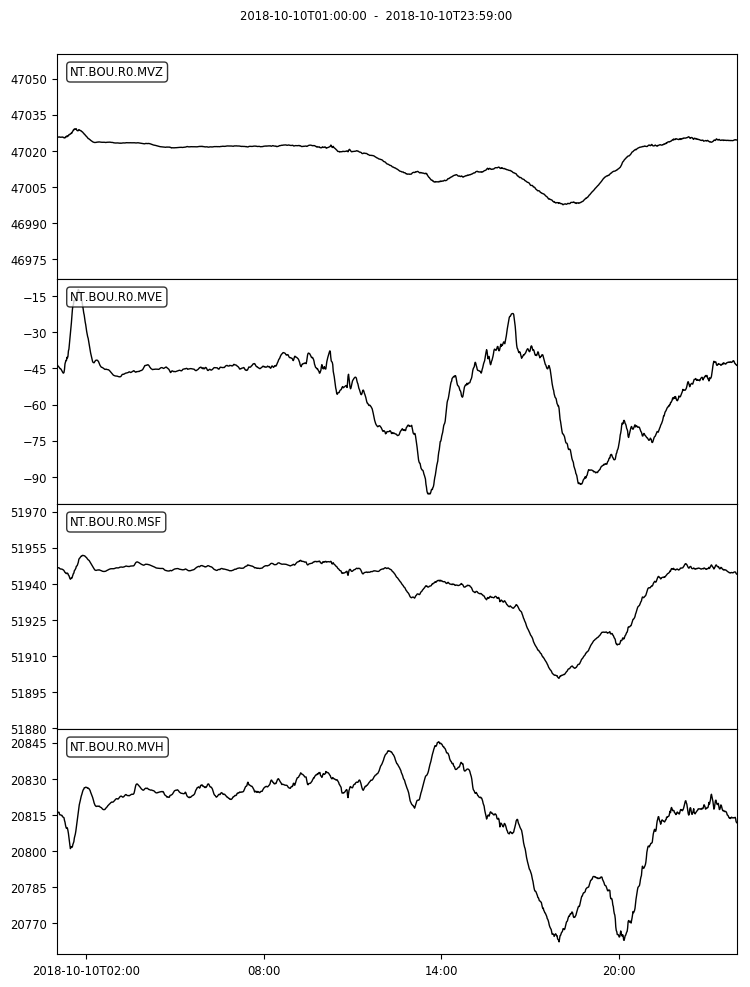

In [15]:
bouf.plot()

In [16]:
bou1[0].stats

             network: NT
             station: BOU
            location: R0
             channel: SVH
           starttime: 2018-10-10T00:59:15.000000Z
             endtime: 2018-10-10T23:59:45.000000Z
       sampling_rate: 1.0
               delta: 1.0
                npts: 82831
               calib: 1.0
         agency_name: United States Geological Survey (USGS)
   conditions_of_use: The Conditions of Use for data provided through INTERMAGNET and acknowledgement templates can be found at www.intermagnet.org
       data_interval: second
  data_interval_type: Average 1-Second
           data_type: variation
    declination_base: 5527
           elevation: 1682
   geodetic_latitude: 40.137
  geodetic_longitude: 254.763
              is_gin: False
      is_intermagnet: False
          processing: ['ObsPy 1.1.0: trim(endtime=UTCDateTime(2018, 10, 10, 23, 59, 45)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2018, 10, 10, 0, 59, 15))']
  sensor_orientation: HDZF

In [17]:
bouf[0].stats

             network: NT
             station: BOU
            location: R0
             channel: MVH
           starttime: 2018-10-10T01:00:00.000000Z
             endtime: 2018-10-10T23:59:00.000000Z
       sampling_rate: 0.016666666666666666
               delta: 60.0
                npts: 1380
               calib: 1.0
         agency_name: United States Geological Survey (USGS)
   conditions_of_use: The Conditions of Use for data provided through INTERMAGNET and acknowledgement templates can be found at www.intermagnet.org
       data_interval: second
  data_interval_type: Average 1-Second
           data_type: variation
    declination_base: 5527
           elevation: 1682
   geodetic_latitude: 40.137
  geodetic_longitude: 254.763
              is_gin: False
      is_intermagnet: False
  sensor_orientation: HDZF
sensor_sampling_rate: 100.0
        station_name: Boulder

In [20]:
bouf[0].data[-1]

20811.804588285882

In [21]:
bouf[0].data[0]

20816.305334453187

In [106]:
82831-90

82741

In [107]:
82741/60

1379.0166666666667

In [108]:
82620/60

1377.0

In [109]:
bou1[0].times()

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 8.2828e+04, 8.2829e+04,
       8.2830e+04])

In [123]:
(82831-90)/60

1379.0166666666667

In [111]:
np.isnan(bou1[0].data).sum()

0

In [112]:
np.isnan(bouf[0].data).sum()

0

In [18]:
import geomagio.iaga2002 as i2

In [27]:
factorytest = i2.IAGA2002Writer()

In [47]:
fh1=open('/Users/aclaycomb/repos/BOU20181010vsec.sec','wb')

In [52]:
fhf=open('/Users/aclaycomb/repos/BOU20181010vmin.min','wb')

In [49]:
factorytest.write(fh1, bou1, ('SVH', 'SVE', 'SVZ', 'SSF'))

In [53]:
factorytest.write(fhf, bouf, ('MVH', 'MVE', 'MVZ', 'MSF'))

In [54]:
bou2 = c.get_timeseries(channels=['SVH','SVE','SVZ','SSF'], starttime=UTCDateTime("2018-09-01T22:59:15Z"), endtime=UTCDateTime("2018-09-01T23:59:45Z"), observatory="BOU", type="variation", interval="second")

In [55]:
bou2f = filterer.process(bou2)

{'SVH': 'MVH', 'SVE': 'MVE', 'SVZ': 'MVZ', 'SSF': 'MSF'}
(3541, 91)
20828.919200138072
20827.77731386921
60
60
(3541, 91)
-52.88243507069091
-44.32389226455428
60
60
(3541, 91)
47043.06023925271
47040.51322540838
60
60
(3541, 91)
51965.67216973773
51962.84290357895
60
60


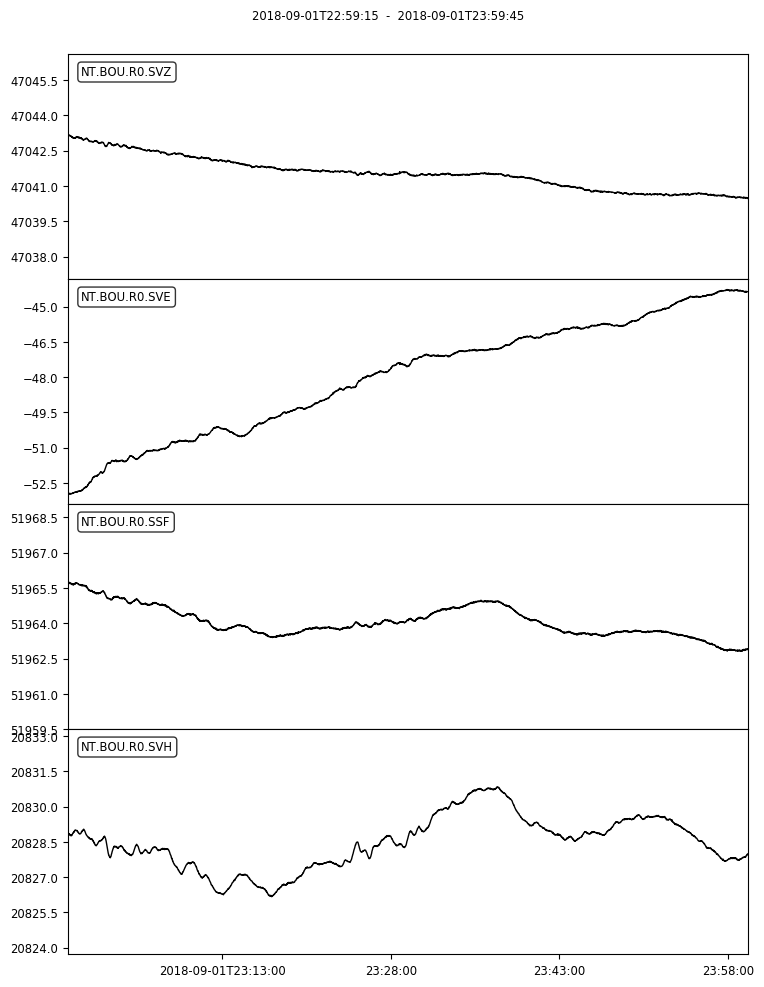

In [57]:
bou2.plot()

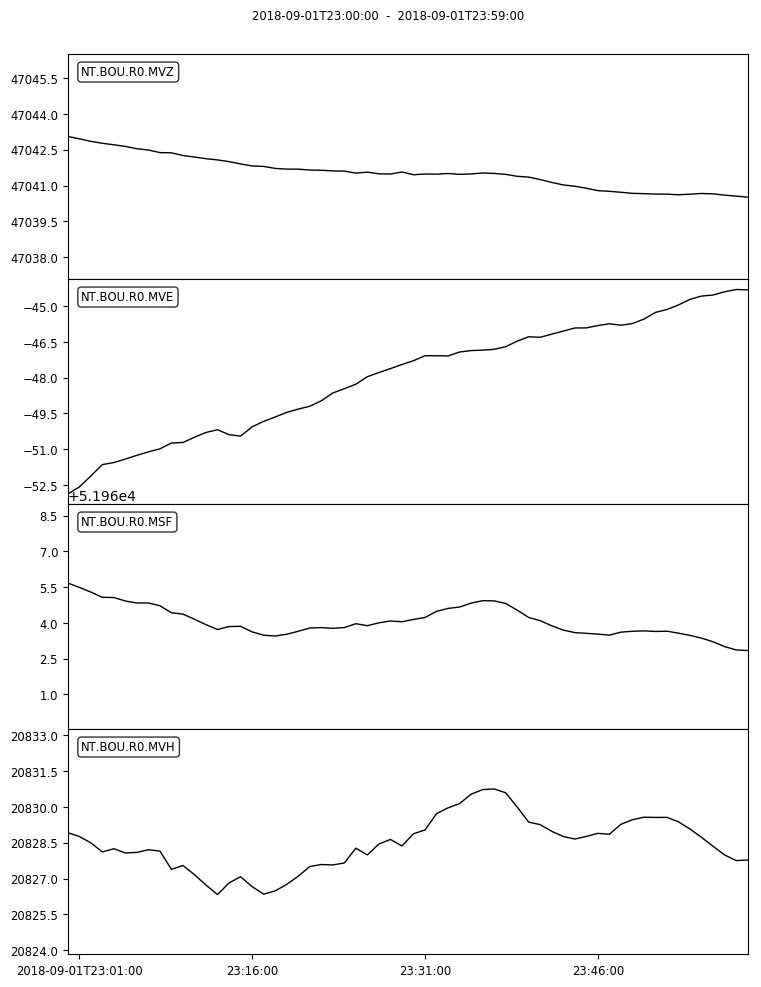

In [58]:
bou2f.plot()

In [71]:
fh2=open('/Users/aclaycomb/repos/BOU20180901vsec.sec','wb')

In [72]:
fh2f=open('/Users/aclaycomb/repos/BOU20180901vmin.min','wb')

In [73]:
factorytest.write(fh2, bou2, ('SVH', 'SVE', 'SVZ', 'SSF'))

In [74]:
factorytest.write(fh2f, bou2f, ('MVH', 'MVE', 'MVZ', 'MSF'))

In [75]:
fh2.close()

In [76]:
fh2f.close()